In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
csvpath = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/atlasV8/csv'

In [3]:
df_midbrain_distance = pd.read_csv(os.path.join(csvpath, 'using_midbrain_distance.csv'))
df_midbrain_allen = pd.read_csv(os.path.join(csvpath, 'using_midbrain_allen.csv'))
df_midbrain_atlas = pd.read_csv(os.path.join(csvpath, 'using_midbrain_atlas.csv'))

In [6]:
df_all_distance = pd.read_csv(os.path.join(csvpath, 'using_all_distance.csv'))
df_all_allen = pd.read_csv(os.path.join(csvpath, 'using_all_allen.csv'))
df_all_atlas = pd.read_csv(os.path.join(csvpath, 'using_all_atlas.csv'))

In [7]:
df_brainstem_distance = pd.read_csv(os.path.join(csvpath, 'using_brainstem_distance.csv'))
df_brainstem_allen = pd.read_csv(os.path.join(csvpath, 'using_brainstem_allen.csv'))
df_brainstem_atlas = pd.read_csv(os.path.join(csvpath, 'using_brainstem_atlas.csv'))

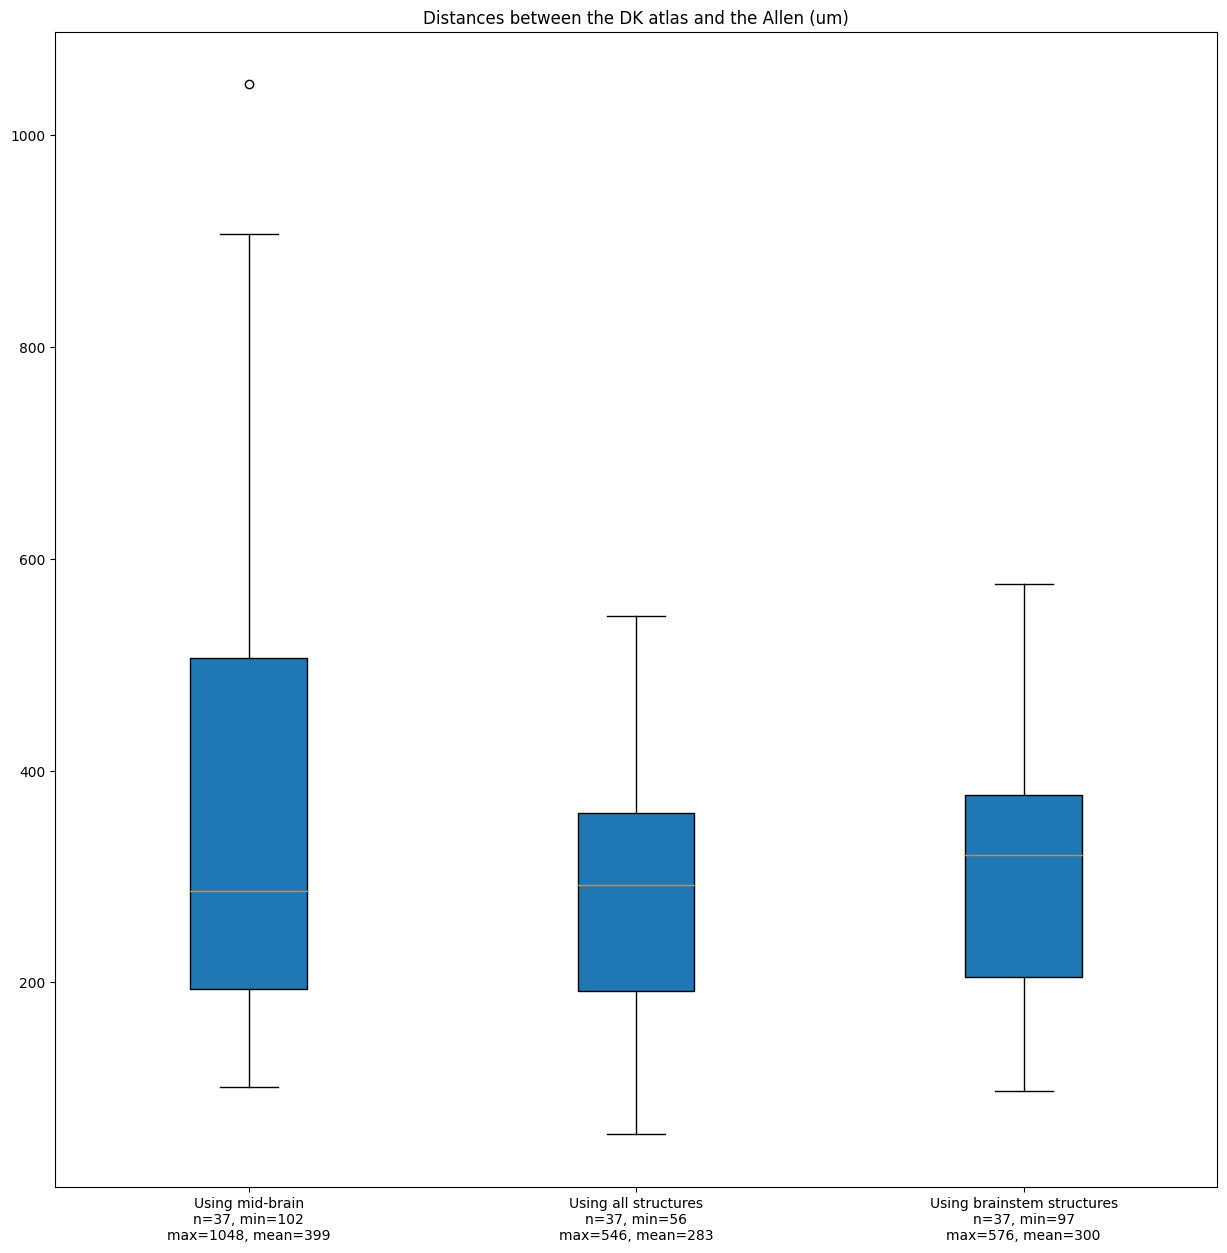

In [12]:
midbrain_distances = df_midbrain_distance.distance
all_distances = df_all_distance.distance
brainstem_distances = df_brainstem_distance.distance
fig, ax = plt.subplots(figsize=(15, 15))
columns = [midbrain_distances, all_distances, brainstem_distances]
ax.boxplot(columns, patch_artist=True)
ax.set_title("Distances between the DK atlas and the Allen (um)")
title1 = f"Using mid-brain\nn={len(midbrain_distances)}, min={round(min(midbrain_distances))}"
title1 += f"\nmax={round(max(midbrain_distances))}, mean={round(np.mean(midbrain_distances))}"
title2 = f"Using all structures\nn={len(all_distances)}, min={round(min(all_distances))}"
title2 += f"\nmax={round(max(all_distances))}, mean={round(np.mean(all_distances))}"
title3 = f"Using brainstem structures\nn={len(brainstem_distances)}, min={round(min(brainstem_distances))}"
title3 += f"\nmax={round(max(brainstem_distances))}, mean={round(np.mean(brainstem_distances))}"
plt.xticks([1,2,3], [title1, title2, title3])
plt.show()

In [ ]:
len(all_distances), min(all_distances), max(all_distances), np.mean(all_distances)

In [ ]:
for i, row in df_midbrain_distance.iterrows():
    print(f'{row[0]} distance={round(row[1],2)}')

In [27]:
for i, row in df_brainstem_distance.iterrows():
    print(f'<tr><td>{row[0]}</td> <td>{round(row[1],2)}</td></tr>')

<tr><td>Sp5O_L</td> <td>97.11</td></tr>
<tr><td>Sp5O_R</td> <td>132.01</td></tr>
<tr><td>DC_L</td> <td>134.63</td></tr>
<tr><td>6N_L</td> <td>138.32</td></tr>
<tr><td>5N_R</td> <td>149.65</td></tr>
<tr><td>VLL_R</td> <td>151.83</td></tr>
<tr><td>LRt_L</td> <td>167.32</td></tr>
<tr><td>SNR_R</td> <td>179.07</td></tr>
<tr><td>5N_L</td> <td>189.11</td></tr>
<tr><td>6N_R</td> <td>204.79</td></tr>
<tr><td>PBG_R</td> <td>214.37</td></tr>
<tr><td>DC_R</td> <td>219.04</td></tr>
<tr><td>7n_R</td> <td>228.57</td></tr>
<tr><td>SNC_R</td> <td>261.94</td></tr>
<tr><td>SNC_L</td> <td>274.29</td></tr>
<tr><td>7n_L</td> <td>276.58</td></tr>
<tr><td>3N_L</td> <td>305.69</td></tr>
<tr><td>LRt_R</td> <td>312.05</td></tr>
<tr><td>3N_R</td> <td>320.01</td></tr>
<tr><td>Sp5I_R</td> <td>320.7</td></tr>
<tr><td>Amb_L</td> <td>323.08</td></tr>
<tr><td>Sp5I_L</td> <td>330.99</td></tr>
<tr><td>VLL_L</td> <td>335.02</td></tr>
<tr><td>4N_L</td> <td>336.31</td></tr>
<tr><td>SC</td> <td>337.04</td></tr>
<tr><td>PBG_

In [15]:
xmin = 8000
xmax = 13000
ymin = 2000
ymax = 6000
zmin = 0
zmax = 25*456

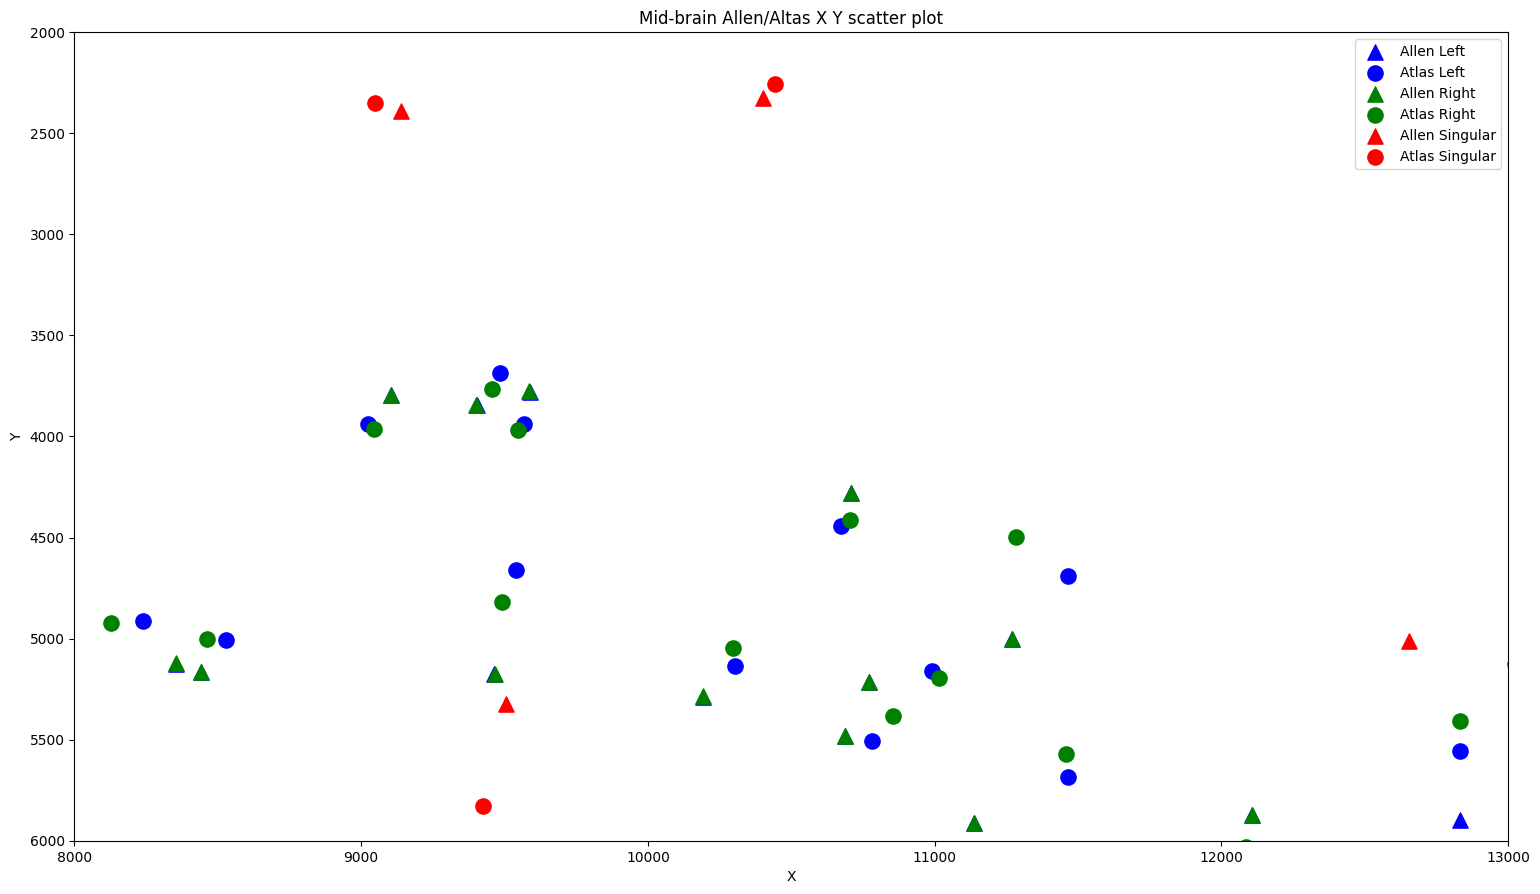

In [17]:
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_midbrain_allen[df_midbrain_allen.S == label]
    atlas_subset = df_midbrain_atlas[df_midbrain_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Y')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('Mid-brain Allen/Altas X Y scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

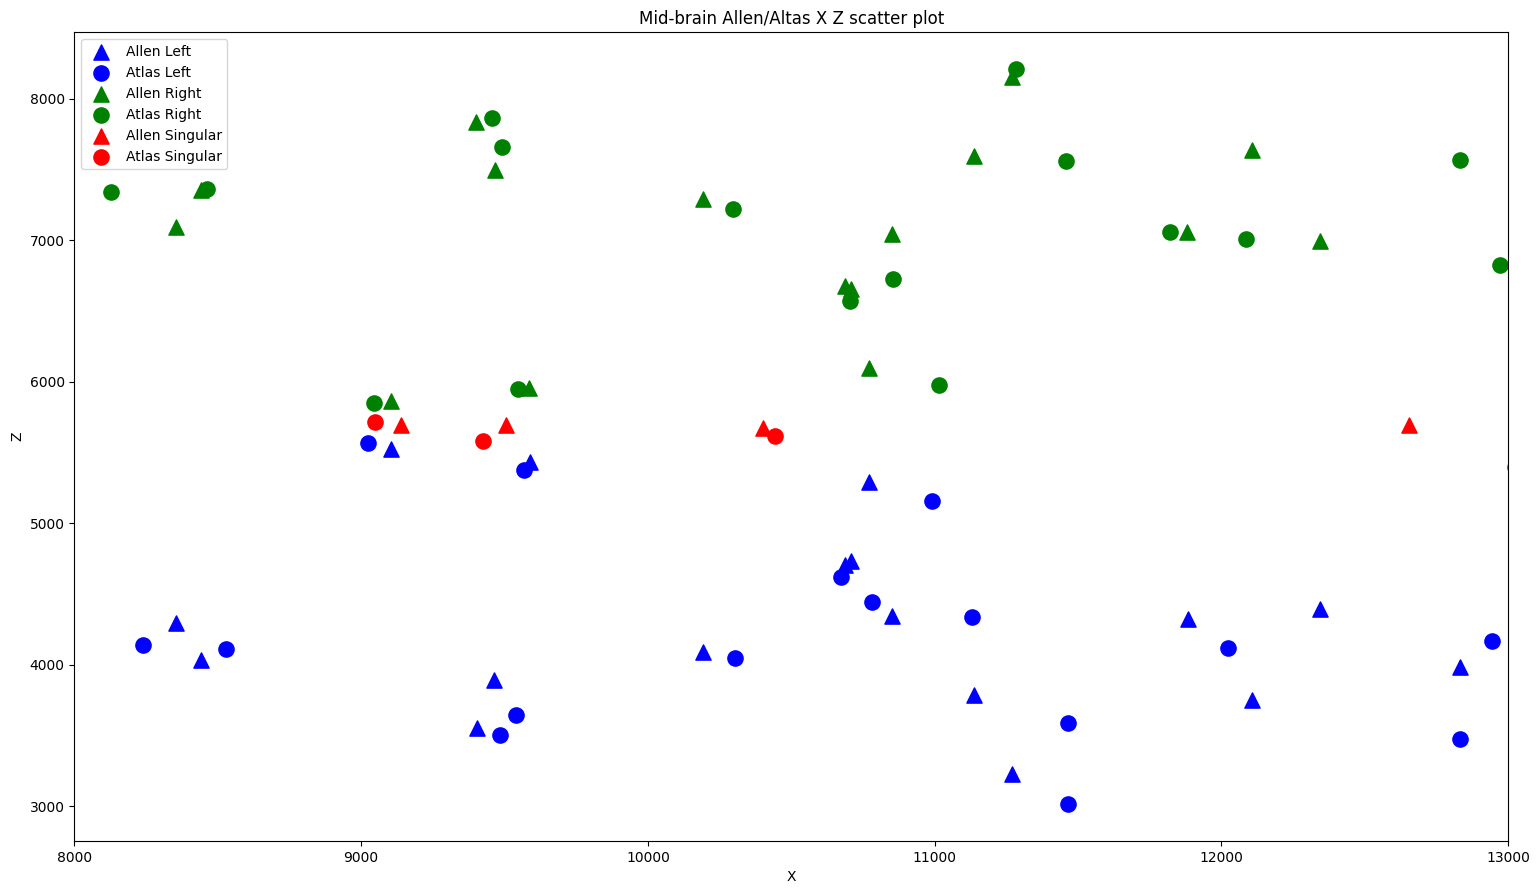

In [18]:
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_midbrain_allen[df_midbrain_allen.S == label]
    atlas_subset = df_midbrain_atlas[df_midbrain_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Z, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Z, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Z')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    #ax.invert_yaxis()
plt.title('Mid-brain Allen/Altas X Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

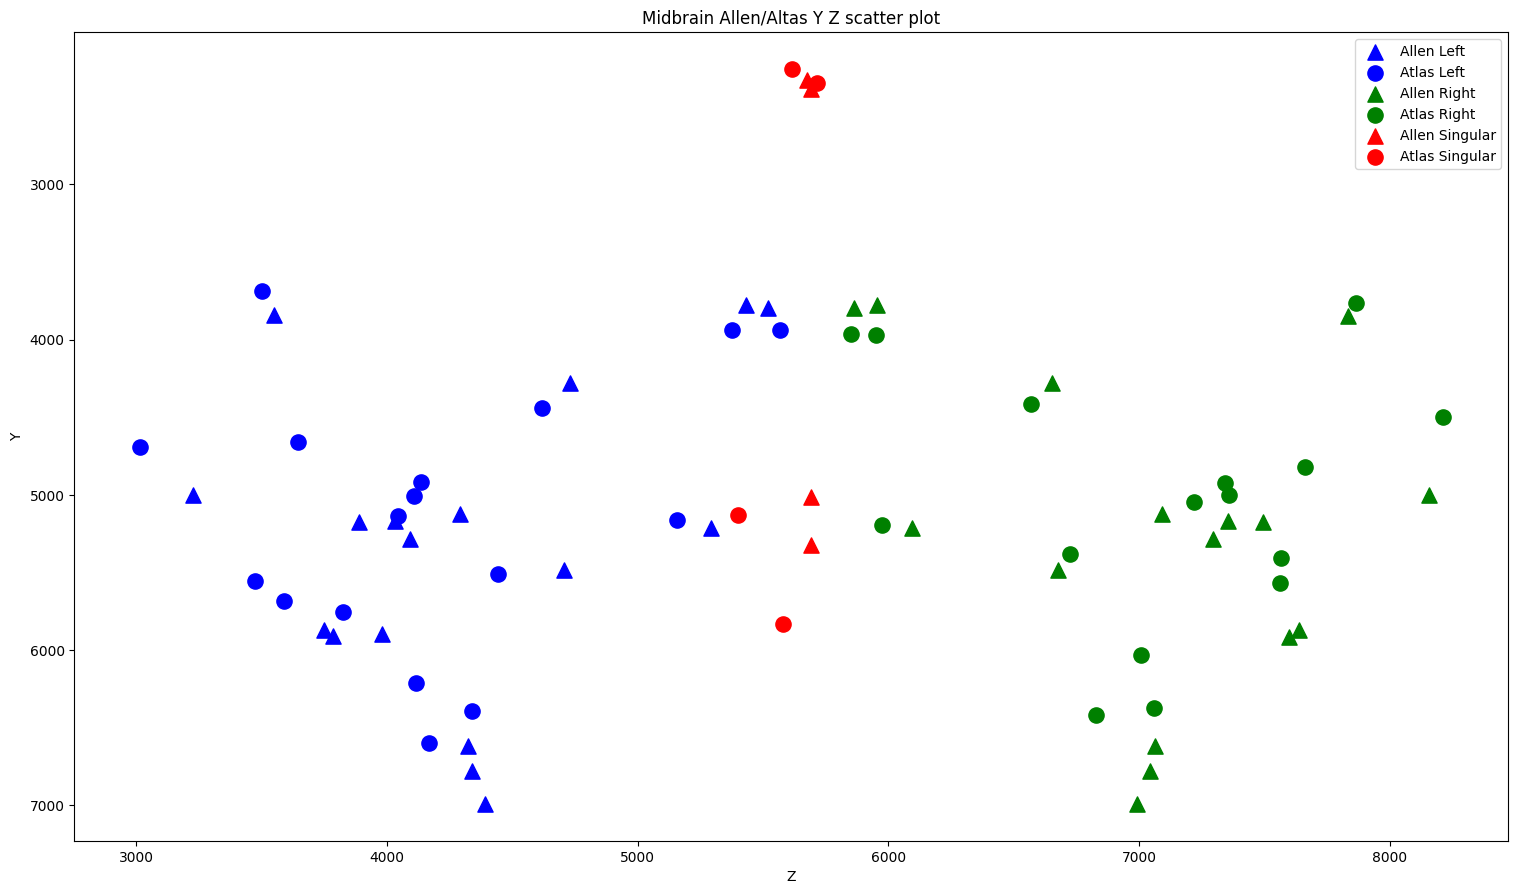

In [19]:
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_midbrain_allen[df_midbrain_allen.S == label]
    atlas_subset = df_midbrain_atlas[df_midbrain_atlas.S == label]
    plt.scatter(allen_subset.Z, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.Z, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('Z')
    plt.ylabel('Y')
    ax = plt.gca()
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('Midbrain Allen/Altas Y Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

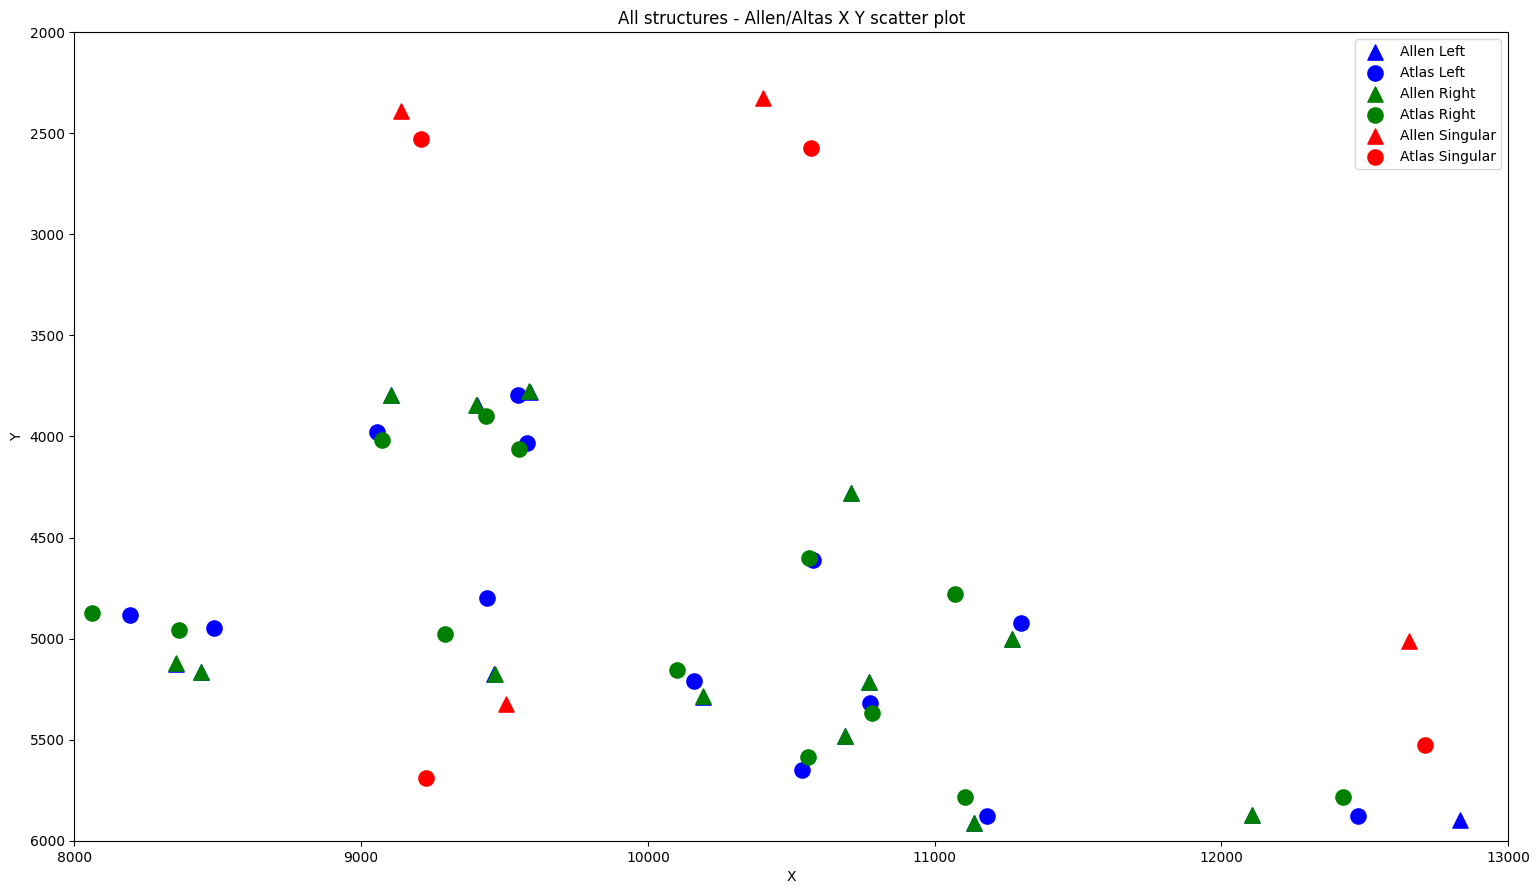

In [20]:
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_all_allen[df_all_allen.S == label]
    atlas_subset = df_all_atlas[df_all_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Y')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('All structures - Allen/Altas X Y scatter plot')    
plt.legend()
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

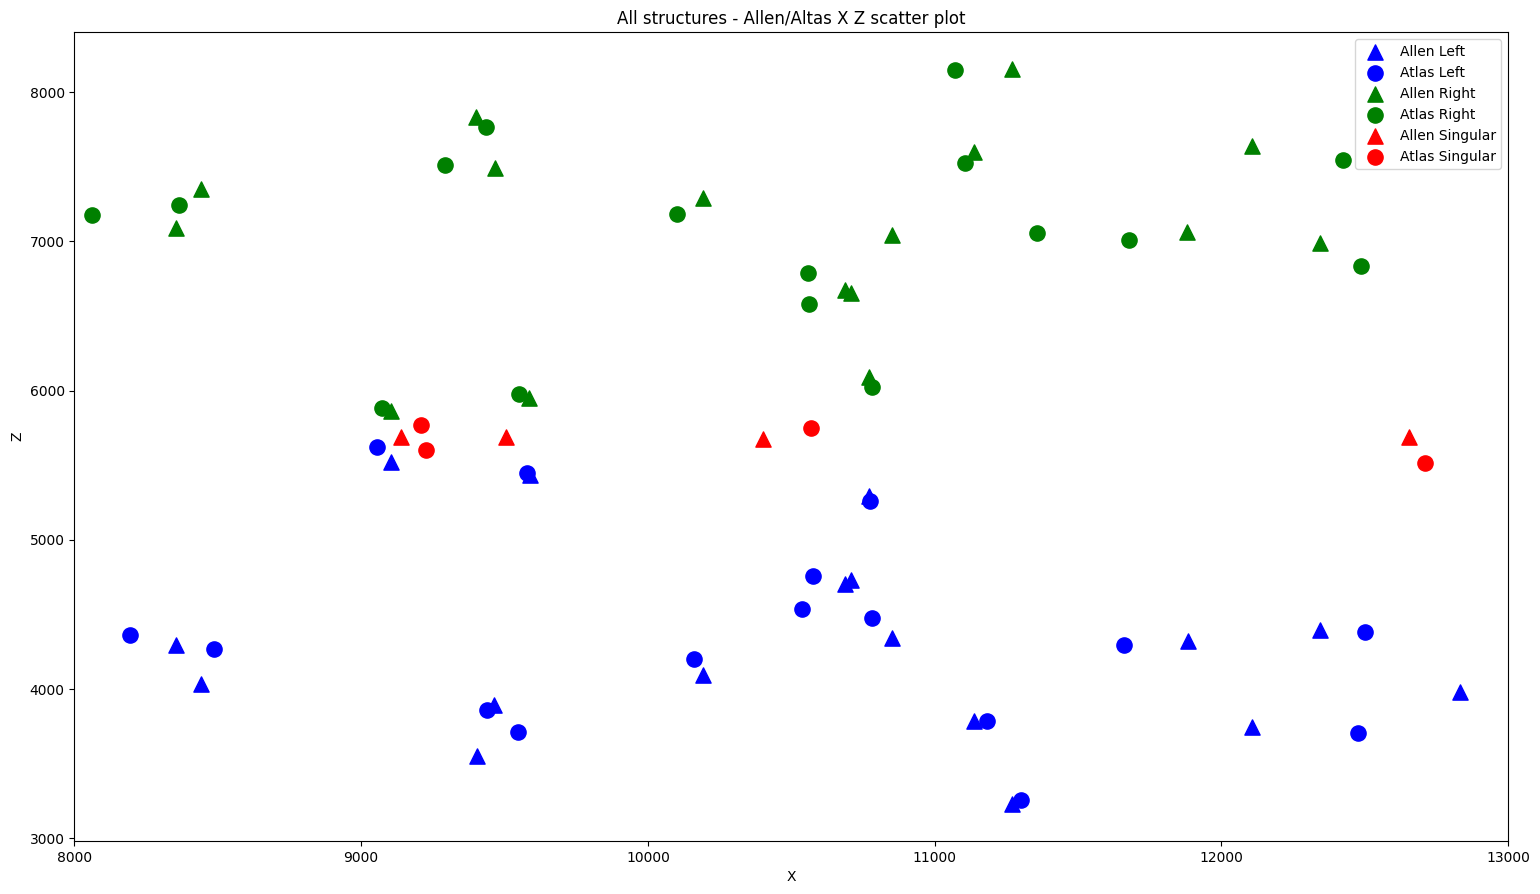

In [21]:
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_all_allen[df_all_allen.S == label]
    atlas_subset = df_all_atlas[df_all_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Z, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Z, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Z')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    #ax.invert_yaxis()
plt.title('All structures - Allen/Altas X Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

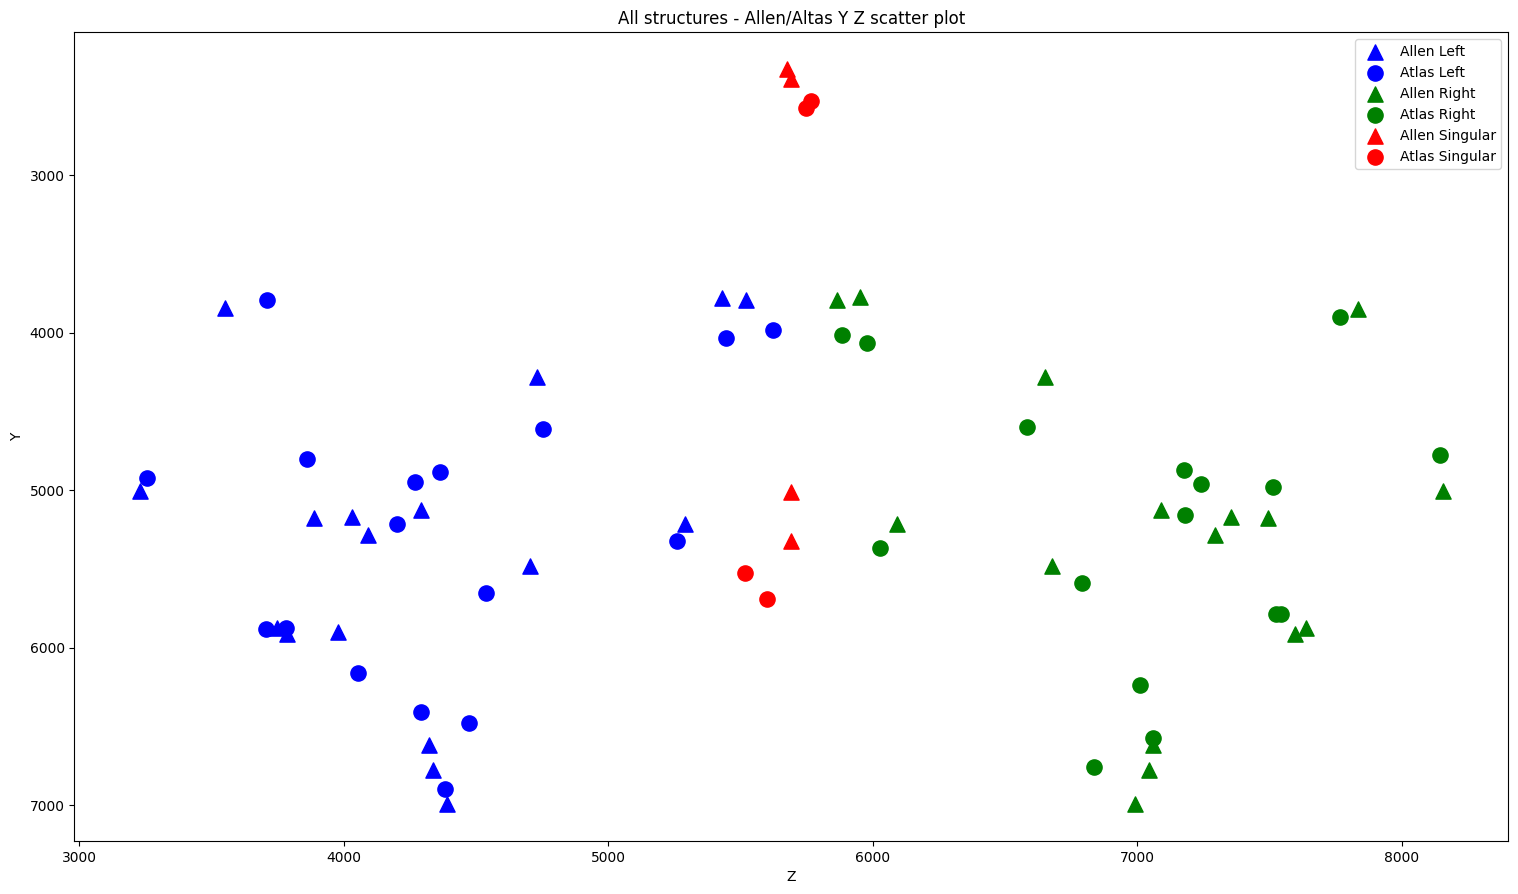

In [22]:
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_all_allen[df_all_allen.S == label]
    atlas_subset = df_all_atlas[df_all_atlas.S == label]
    plt.scatter(allen_subset.Z, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.Z, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('Z')
    plt.ylabel('Y')
    ax = plt.gca()
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('All structures - Allen/Altas Y Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

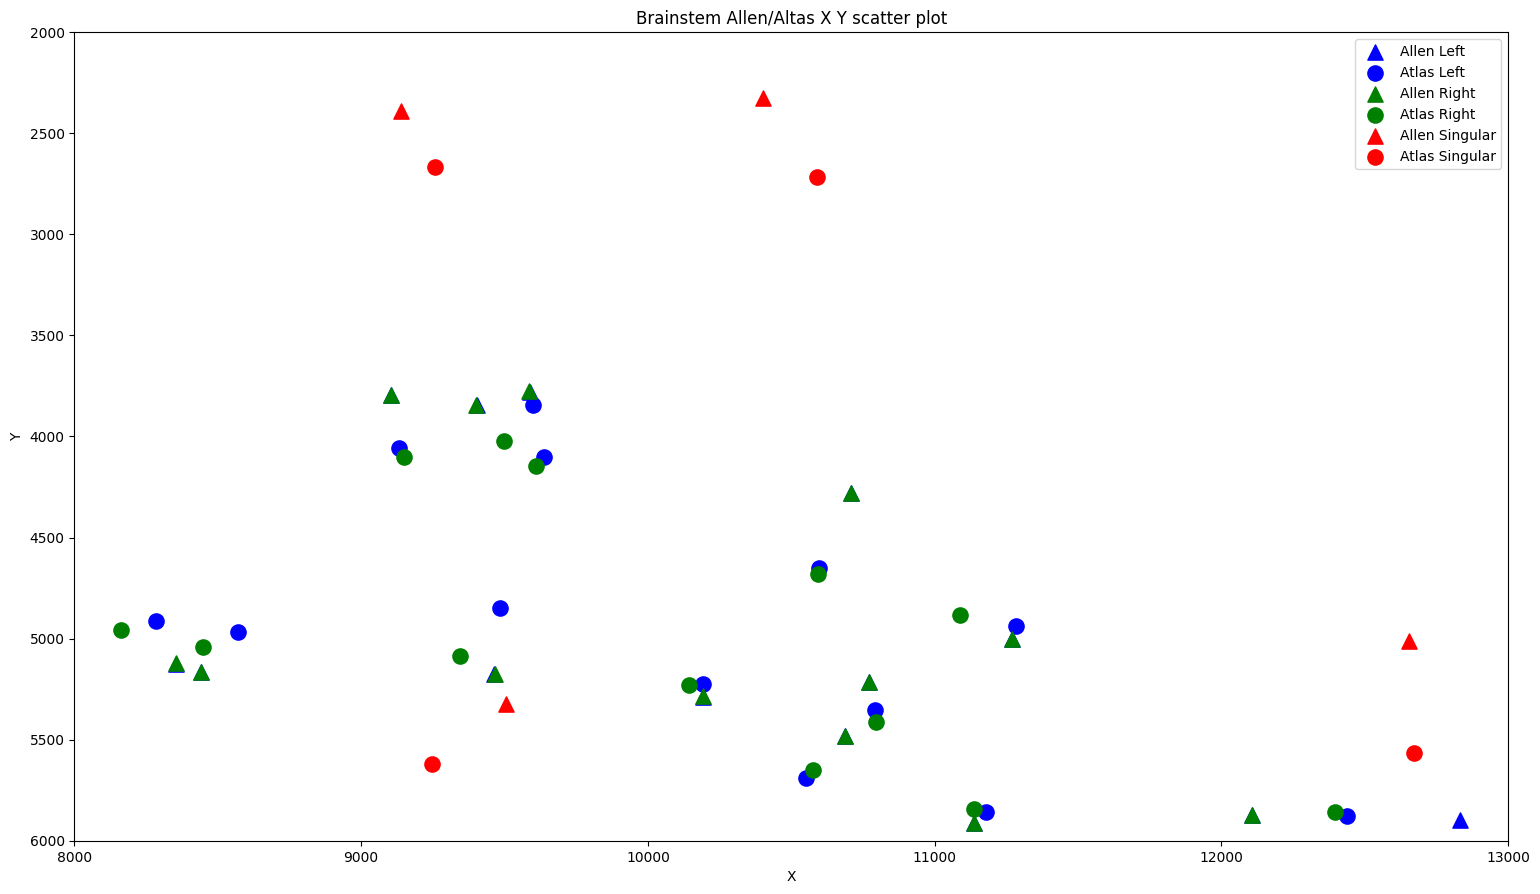

In [23]:
# xy
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_brainstem_allen[df_brainstem_allen.S == label]
    atlas_subset = df_brainstem_atlas[df_brainstem_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Y')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('Brainstem Allen/Altas X Y scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

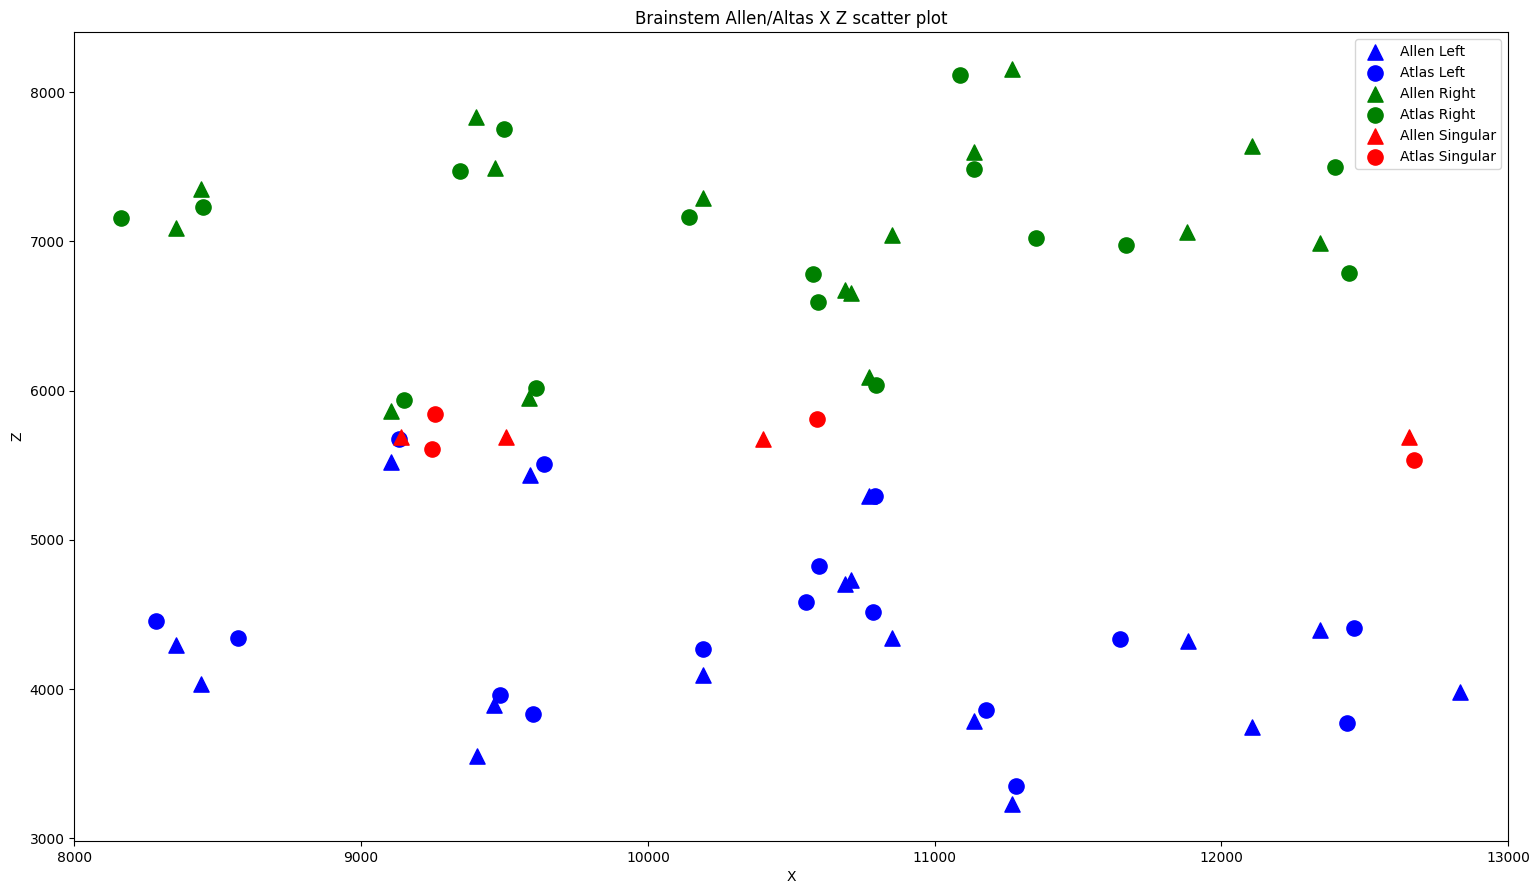

In [24]:
# xz
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_brainstem_allen[df_brainstem_allen.S == label]
    atlas_subset = df_brainstem_atlas[df_brainstem_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Z, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Z, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Z')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    #ax.invert_yaxis()
plt.title('Brainstem Allen/Altas X Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

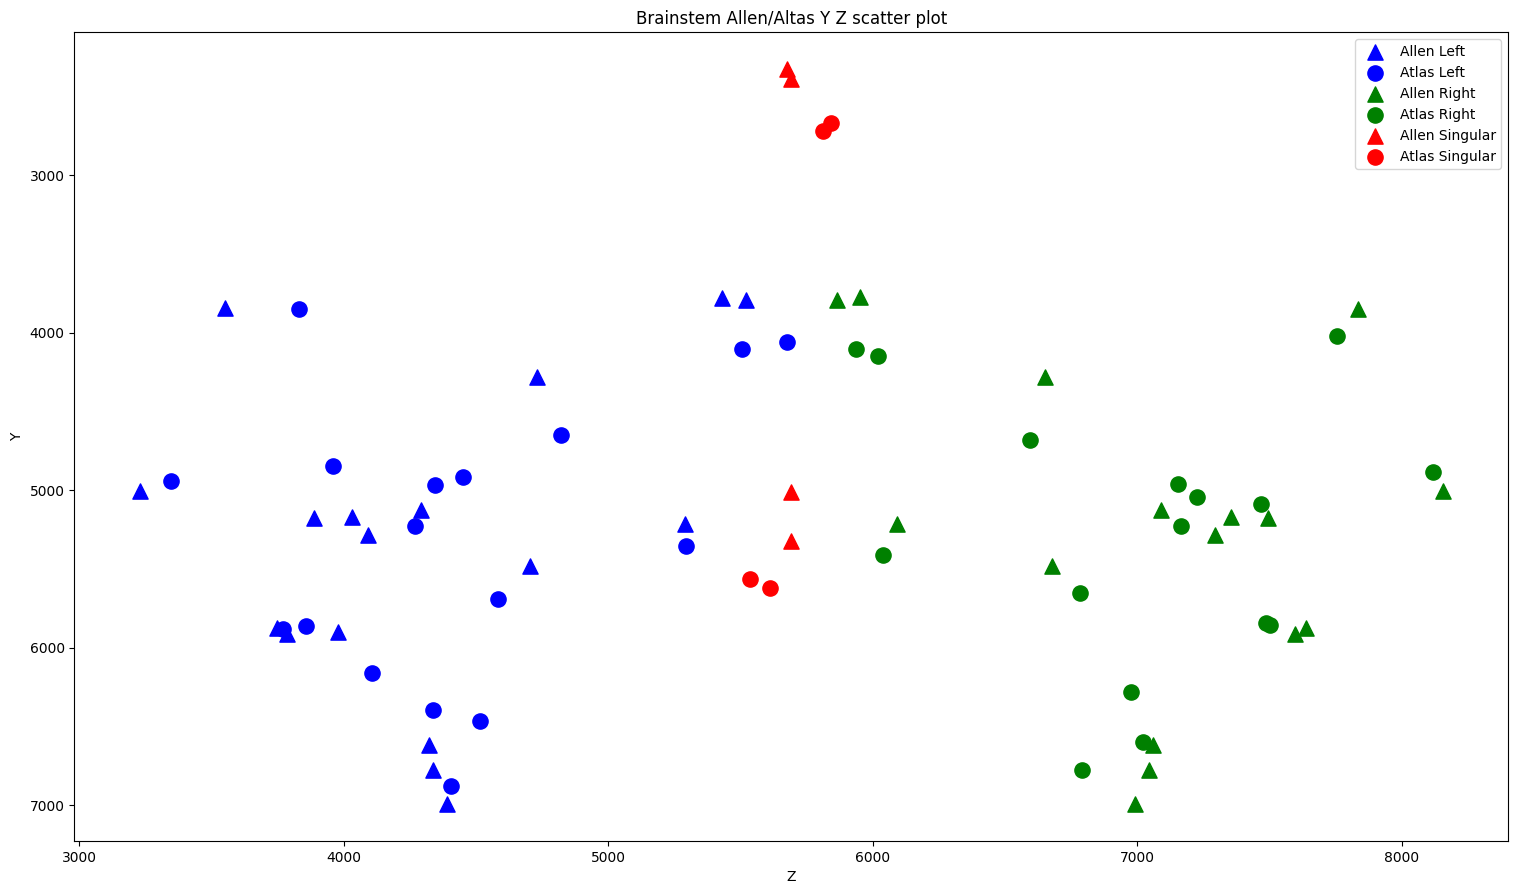

In [25]:
# yz
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_brainstem_allen[df_brainstem_allen.S == label]
    atlas_subset = df_brainstem_atlas[df_brainstem_atlas.S == label]
    plt.scatter(allen_subset.Z, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.Z, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('Z')
    plt.ylabel('Y')
    ax = plt.gca()
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('Brainstem Allen/Altas Y Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)